In [1]:
from pyspark.sql import SparkSession
from IPython.display import display, clear_output
import time
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [2]:
spark = SparkSession.builder \
        .appName('kafka') \
        .getOrCreate()

In [3]:
stream_df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "broker:29092") \
  .option("startingOffsets", "latest") \
  .option("subscribe", "stock-trades") \
  .load()

In [4]:
stream_df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [5]:
raw_stream = stream_df \
    .writeStream \
    .format("memory") \
    .queryName("raw_stocktrade_view") \
    .start()

In [6]:
clear_output(wait=True)
time.sleep(10)

In [7]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM raw_stocktrade_view').show(20))
time.sleep(1)

+----------------+--------------------+------------+---------+------+--------------------+-------------+
|             key|               value|       topic|partition|offset|           timestamp|timestampType|
+----------------+--------------------+------------+---------+------+--------------------+-------------+
|[5A 54 45 53 54]|[7B 22 73 63 68 6...|stock-trades|        0|399374|2021-06-07 01:09:...|            0|
|[5A 54 45 53 54]|[7B 22 73 63 68 6...|stock-trades|        0|399375|2021-06-07 01:09:...|            0|
|[5A 57 5A 5A 54]|[7B 22 73 63 68 6...|stock-trades|        0|399376|2021-06-07 01:09:...|            0|
|[5A 54 45 53 54]|[7B 22 73 63 68 6...|stock-trades|        0|399377|2021-06-07 01:09:...|            0|
|[5A 57 5A 5A 54]|[7B 22 73 63 68 6...|stock-trades|        0|399378|2021-06-07 01:09:...|            0|
|[5A 54 45 53 54]|[7B 22 73 63 68 6...|stock-trades|        0|399379|2021-06-07 01:09:...|            0|
|[5A 4A 5A 5A 54]|[7B 22 73 63 68 6...|stock-trades|   

None

In [8]:
time.sleep(1)

In [9]:
raw_stream.stop()

In [10]:
string_stream_df = stream_df \
    .withColumn("key", stream_df["key"].cast(StringType())) \
    .withColumn("value", stream_df["value"].cast(StringType()))

In [11]:
string_stream = string_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("string_stocktrade_view") \
    .start()

In [12]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM string_stocktrade_view').show(20, False))
time.sleep(1)

+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+------

None

In [13]:
string_stream.stop()

In [14]:
schema_stocktrade = StructType([
    StructField('payload', StructType([
        StructField("side", StringType(),  True),
        StructField("quantity", IntegerType(), True),
        StructField("symbol", StringType(),  True),
        StructField("price", IntegerType(),  True),
        StructField("account", StringType(),  True),
        StructField("userid", StringType(),  True)      
    ]))
])

In [15]:
json_stream_df = string_stream_df\
    .withColumn("value", F.from_json("value", schema_stocktrade))

In [16]:
json_stream_df.printSchema()

root
 |-- key: string (nullable = true)
 |-- value: struct (nullable = true)
 |    |-- payload: struct (nullable = true)
 |    |    |-- side: string (nullable = true)
 |    |    |-- quantity: integer (nullable = true)
 |    |    |-- symbol: string (nullable = true)
 |    |    |-- price: integer (nullable = true)
 |    |    |-- account: string (nullable = true)
 |    |    |-- userid: string (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [17]:
json_stream = json_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("extract_stock_view") \
    .start()

In [18]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM extract_stock_view').show(20))
time.sleep(1)

+-----+--------------------+------------+---------+------+--------------------+-------------+
|  key|               value|       topic|partition|offset|           timestamp|timestampType|
+-----+--------------------+------------+---------+------+--------------------+-------------+
|ZVZZT|{{SELL, 4408, ZVZ...|stock-trades|        0|402276|2021-06-07 01:10:...|            0|
| ZBZX|{{BUY, 4362, ZBZX...|stock-trades|        0|402277|2021-06-07 01:10:...|            0|
|ZXZZT|{{SELL, 4522, ZXZ...|stock-trades|        0|402278|2021-06-07 01:10:...|            0|
|ZVZZT|{{SELL, 848, ZVZZ...|stock-trades|        0|402279|2021-06-07 01:10:...|            0|
|ZWZZT|{{SELL, 2794, ZWZ...|stock-trades|        0|402280|2021-06-07 01:10:...|            0|
|ZXZZT|{{BUY, 3438, ZXZZ...|stock-trades|        0|402281|2021-06-07 01:10:...|            0|
|ZWZZT|{{BUY, 3303, ZWZZ...|stock-trades|        0|402282|2021-06-07 01:10:...|            0|
|ZTEST|{{SELL, 4782, ZTE...|stock-trades|        0|402283|20

None

In [19]:
json_stream.stop()

In [20]:
stocktrade_stream_df = json_stream_df \
    .select( \
        F.col("key").alias("event_key"), \
        F.col("topic").alias("event_topic"), \
        F.col("timestamp").alias("event_timestamp"), \
        "value.payload.account", \
        "value.payload.symbol", \
        "value.payload.side", \
        "value.payload.price", \
        "value.payload.quantity", \
        "value.payload.userid"
    )

In [21]:
stocktrade_stream_df.printSchema()

root
 |-- event_key: string (nullable = true)
 |-- event_topic: string (nullable = true)
 |-- event_timestamp: timestamp (nullable = true)
 |-- account: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- side: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- userid: string (nullable = true)



In [22]:
stocktrade_stream = stocktrade_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrade_view") \
    .start()

In [23]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrade_view').show(20))
time.sleep(1)

+---------+------------+--------------------+-------+------+----+-----+--------+------+
|event_key| event_topic|     event_timestamp|account|symbol|side|price|quantity|userid|
+---------+------------+--------------------+-------+------+----+-----+--------+------+
|    ZWZZT|stock-trades|2021-06-07 01:11:...| LMN456| ZWZZT| BUY|  825|    3061|User_1|
|    ZWZZT|stock-trades|2021-06-07 01:11:...| LMN456| ZWZZT| BUY|  112|    1849|User_9|
|    ZVZZT|stock-trades|2021-06-07 01:11:...| XYZ789| ZVZZT|SELL|  999|     505|User_2|
|    ZXZZT|stock-trades|2021-06-07 01:11:...| LMN456| ZXZZT| BUY|  787|    2044|User_2|
|    ZJZZT|stock-trades|2021-06-07 01:11:...| LMN456| ZJZZT| BUY|   81|      51|User_5|
|    ZJZZT|stock-trades|2021-06-07 01:11:...| ABC123| ZJZZT| BUY|  863|     905|User_9|
|    ZJZZT|stock-trades|2021-06-07 01:11:...| ABC123| ZJZZT|SELL|  511|     878|User_1|
|    ZXZZT|stock-trades|2021-06-07 01:11:...| LMN456| ZXZZT| BUY|  415|    3660|User_1|
|    ZXZZT|stock-trades|2021-06-

None

In [24]:
clear_output(wait=True)
display(spark.sql('SELECT event_key, COUNT(1) AS count, round(mean(price),0) as price, round(mean(quantity),0) as qty FROM stocktrade_view GROUP BY 1').show(20))
time.sleep(1)

+---------+-----+-----+------+
|event_key|count|price|   qty|
+---------+-----+-----+------+
|    ZXZZT|   89|437.0|2431.0|
|    ZVZZT|   87|575.0|2378.0|
|    ZTEST|   88|498.0|2462.0|
|    ZWZZT|   80|474.0|2580.0|
|    ZJZZT|   92|507.0|2374.0|
|      ZVV|   79|472.0|2340.0|
|     ZBZX|   81|511.0|2463.0|
+---------+-----+-----+------+



None

In [25]:
stocktrade_stream.stop()

In [26]:
window_duration = '60 seconds'
slide_duration = '10 seconds'

In [27]:
windowed_count_df = stocktrade_stream_df \
    .withWatermark("event_timestamp", "1 minutes") \
    .groupBy(F.window(stocktrade_stream_df.event_timestamp, window_duration, slide_duration), stocktrade_stream_df.symbol) \
    .count()

In [28]:
count_stream = windowed_count_df \
    .writeStream \
    .format("memory") \
    .outputMode("Complete") \
    .queryName("count_view") \
    .start()

In [86]:
while True:
    clear_output(wait=True)
    display(spark.sql('SELECT * FROM count_view LIMIT 20').show())
    time.sleep(1)

+--------------------+------+-----+
|              window|symbol|count|
+--------------------+------+-----+
|{2021-06-06 11:50...| ZTEST|   30|
|{2021-06-06 11:51...| ZWZZT|   26|
|{2021-06-06 11:50...| ZTEST|   30|
|{2021-06-06 11:50...|  ZBZX|   33|
|{2021-06-06 11:50...|  ZBZX|   33|
|{2021-06-06 11:51...|  ZBZX|   21|
|{2021-06-06 11:50...| ZVZZT|   35|
|{2021-06-06 11:50...| ZJZZT|   39|
|{2021-06-06 11:50...| ZVZZT|   35|
|{2021-06-06 11:50...| ZTEST|   12|
|{2021-06-06 11:50...| ZXZZT|   16|
|{2021-06-06 11:50...| ZWZZT|   32|
|{2021-06-06 11:51...|   ZVV|   31|
|{2021-06-06 11:50...|  ZBZX|   33|
|{2021-06-06 11:50...|  ZBZX|   33|
|{2021-06-06 11:50...| ZWZZT|   32|
|{2021-06-06 11:50...| ZXZZT|   52|
|{2021-06-06 11:50...| ZVZZT|   10|
|{2021-06-06 11:50...|   ZVV|   43|
|{2021-06-06 11:50...| ZVZZT|   35|
+--------------------+------+-----+



None

KeyboardInterrupt: 

In [67]:
# count_stream.stop()

In [29]:
########################
# Visualisations
########################
# Graphing real-time data
# loading packages
import time
import random as rd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

# sample data from stocktrade_view
x_y = spark.sql('''SELECT * FROM stocktrade_view order by event_timestamp desc limit 2000''')
x_y_df = x_y.toPandas()
x_y_df

,event_key,event_topic,event_timestamp,account,symbol,side,price,quantity,userid
0,ZVV,stock-trades,2021-06-07 01:11:29.144,XYZ789,ZVV,SELL,274,2994,User_6
1,ZVZZT,stock-trades,2021-06-07 01:11:29.140,ABC123,ZVZZT,SELL,429,2081,User_4
2,ZVZZT,stock-trades,2021-06-07 01:11:29.112,ABC123,ZVZZT,BUY,591,518,User_3
3,ZVZZT,stock-trades,2021-06-07 01:11:29.107,ABC123,ZVZZT,SELL,147,3518,User_4
4,ZWZZT,stock-trades,2021-06-07 01:11:29.104,ABC123,ZWZZT,SELL,909,4786,User_2
...,...,...,...,...,...,...,...,...,...
739,ZJZZT,stock-trades,2021-06-07 01:11:10.728,LMN456,ZJZZT,BUY,81,51,User_5
740,ZXZZT,stock-trades,2021-06-07 01:11:10.687,LMN456,ZXZZT,BUY,787,2044,User_2
741,ZVZZT,stock-trades,2021-06-07 01:11:10.666,XYZ789,ZVZZT,SELL,999,505,User_2
742,ZWZZT,stock-trades,2021-06-07 01:11:10.636,LMN456,ZWZZT,BUY,112,1849,User_9


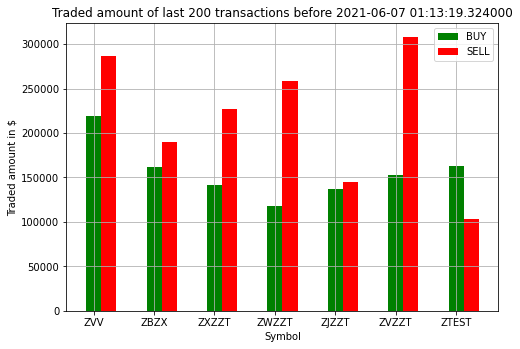

KeyboardInterrupt: 

In [30]:
stocktrade_stream.stop()
# Plotting tranded amount vs stock (symbol)
# taking the most recent 200 transactions
x_y = spark.sql('''SELECT 
                        symbol
                        , side
                        , sum(price*quantity)/100 as traded_amount_in_dollars
                    FROM (select * from stocktrade_view order by event_timestamp desc limit 200) as current
                    group by 
                            side
                            , symbol
                        ''')
x_y_df = x_y.toPandas()
# sorting values by 2 columns
x_y_df = x_y_df.sort_values(by = ['symbol', 'side'])
print(x_y_df)


def live_bar_plot(df, figsize=(7,5), title = 'Traded amount of last 200 transactions'):
    clear_output(wait=True)
    labels = list(df.symbol.unique())

    data = [ df[df['side'] == 'BUY']['traded_amount_in_dollars']
            ,df[df['side'] == 'SELL']['traded_amount_in_dollars']
           ]
    X = np.arange(len(df.symbol.unique()))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X + 0.00, data[0], color = 'g', width = 0.25)
    ax.bar(X + 0.25, data[1], color = 'r', width = 0.25)
    ax.legend(labels=['BUY', 'SELL'])
    ax.set_xticks(X)
    ax.set_xticklabels(labels)


    plt.title(title)
    plt.grid(True)
    plt.xlabel('Symbol')
    plt.ylabel('Traded amount in $')
    plt.show();

stocktrade_stream = stocktrade_stream_df \
    .writeStream \
    .format("memory") \
    .queryName("stocktrade_view") \
    .start()    



while True:
    x_y= spark.sql('''SELECT 
                        symbol
                        , side
                        , sum(price*quantity)/100 as traded_amount_in_dollars
                        , max(event_timestamp) as max_event_timestamp
                    FROM (select * from stocktrade_view order by event_timestamp desc limit 200) as current
                    group by 
                            side
                            , symbol
                    ''')
    
    x_y_df = x_y.toPandas()
    
    if x_y_df.shape[0] > 0:
        # sorting values by 2 columns
        x_y_df = x_y_df.sort_values(by = ['symbol', 'side'])

        x_y_df = x_y.toPandas()
        print(x_y_df)  

        live_bar_plot(x_y_df, title = f'Traded amount of last 200 transactions before {max(x_y_df.max_event_timestamp)}') 

    # updating every 10 s
    time.sleep(10)

In [ ]:
def live_scatter_plot(x, y, figsize=(7,5), title='Testing Update'):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.xlim(0, max(x))
    plt.ylim(0, max(y))
    x= [float(i) for i in x]
    y= [float(i) for i in y]

    if len(x) > 1:
        plt.scatter(x,y, label='axis y', color='k')
        # printing line of best fit
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, [x * m for x in x] + b)

    plt.title(title)
    plt.grid(True)
    plt.xlabel('Price')
    plt.ylabel('Quantity')
    plt.show();


while True: 
    x_y = spark.sql('''SELECT * FROM stocktrade_view order by event_timestamp desc limit 200''')
    x_y_df = x_y.toPandas()
    print(x_y_df)  
    live_scatter_plot(x_y_df.price, x_y_df.quantity, title = f'Quantity vs Price in last 200 transactions before {max(x_y_df.event_timestamp)}') 
    time.sleep(10)

In [ ]:
# Build Spark Query 2 using view "stocktraide_view" - order by timestamp

In [31]:
clear_output(wait=True)
display(spark.sql('SELECT * FROM stocktrade_view order by event_timestamp desc').show(15))
time.sleep(1)

+---------+------------+--------------------+-------+------+----+-----+--------+------+
|event_key| event_topic|     event_timestamp|account|symbol|side|price|quantity|userid|
+---------+------------+--------------------+-------+------+----+-----+--------+------+
|    ZTEST|stock-trades|2021-06-07 01:13:...| ABC123| ZTEST| BUY|  374|    3533|User_1|
|    ZWZZT|stock-trades|2021-06-07 01:13:...| LMN456| ZWZZT| BUY|  683|    4240|User_1|
|     ZBZX|stock-trades|2021-06-07 01:13:...| ABC123|  ZBZX|SELL|  739|    4355|User_5|
|    ZWZZT|stock-trades|2021-06-07 01:13:...| XYZ789| ZWZZT| BUY|  713|    3298|User_6|
|     ZBZX|stock-trades|2021-06-07 01:13:...| ABC123|  ZBZX| BUY|  383|    1177|User_4|
|     ZBZX|stock-trades|2021-06-07 01:13:...| LMN456|  ZBZX| BUY|   64|    4445|User_7|
|    ZJZZT|stock-trades|2021-06-07 01:13:...| XYZ789| ZJZZT|SELL|  401|     839|User_9|
|    ZVZZT|stock-trades|2021-06-07 01:13:...| LMN456| ZVZZT|SELL|  762|    1553|User_6|
|    ZXZZT|stock-trades|2021-06-

None

In [69]:
# Export Query 2 to dataframe then parquet file

In [39]:
from pyspark import SparkFiles
from pyspark.sql import SQLContext
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [84]:
df = sqlContext.sql('SELECT * FROM stocktrade_view')
df.count()
# Wait for minutes, run this cell again, ensuring stream more than 13000 rows to the training and testing data.

498378

In [85]:
df_train = sqlContext.sql('SELECT * FROM stocktrade_view order by event_timestamp limit 10000')
df_test = sqlContext.sql('SELECT * FROM stocktrade_view order by event_timestamp desc limit 3000')

In [86]:
df_train.write.parquet('./query2_alldata.parquet',mode='append')

In [ ]:
# Read parquet file for visualisation and machine learning

In [87]:
query2_df = sqlContext.read.parquet('./query_alldata.parquet')
query2_df.show(20)

+---------+------------+--------------------+------+-------+------+----+--------+-----+
|event_key| event_topic|     event_timestamp|userid|account|symbol|side|quantity|price|
+---------+------------+--------------------+------+-------+------+----+--------+-----+
|    ZVZZT|stock-trades|2021-06-06 03:06:...|User_5| ABC123| ZVZZT|SELL|    1401|  287|
|    ZVZZT|stock-trades|2021-06-06 03:06:...|User_3| LMN456| ZVZZT|SELL|     935|   98|
|     ZBZX|stock-trades|2021-06-06 03:06:...|User_1| LMN456|  ZBZX| BUY|    1795|  306|
|      ZVV|stock-trades|2021-06-06 03:06:...|User_2| LMN456|   ZVV| BUY|    1220|  106|
|    ZJZZT|stock-trades|2021-06-06 03:06:...|User_4| XYZ789| ZJZZT|SELL|     189|  522|
|    ZXZZT|stock-trades|2021-06-06 03:06:...|User_7| ABC123| ZXZZT| BUY|    3060|  545|
|    ZVZZT|stock-trades|2021-06-06 03:06:...|User_1| XYZ789| ZVZZT|SELL|    3732|  757|
|      ZVV|stock-trades|2021-06-06 03:06:...|User_8| XYZ789|   ZVV|SELL|    4210|  614|
|    ZWZZT|stock-trades|2021-06-

In [88]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

In [89]:
from pyspark.ml.feature import StringIndexer,VectorAssembler, VectorIndexer
from pyspark.ml.feature import OneHotEncoder

In [105]:
cat_cols = ['userid','account','symbol','side']

In [106]:
stages = []

In [107]:
for cat_col in cat_cols:
    col_indexer = StringIndexer(inputCol=cat_col, outputCol =f"{cat_col}_ind")
    col_encoder = OneHotEncoder(inputCols=[f"{cat_col}_ind"],outputCols=[f"{cat_col}_ohe"])
    stages += [col_indexer, col_encoder]

In [108]:
num_cols = ['price']

In [109]:
cat_cols_ohe = [f"{cat_col}_ohe" for cat_col in cat_cols]

In [110]:
assembler = VectorAssembler(inputCols=cat_cols_ohe+num_cols, outputCol="features")

In [111]:
regression = LinearRegression(labelCol='quantity',regParam = 0, maxIter = 10)

In [112]:
stages += [assembler,regression]

In [113]:
print(stages)

[StringIndexer_d08e2be0b2c0, OneHotEncoder_eb30f90aedbb, StringIndexer_05101df64eec, OneHotEncoder_2981696932ca, StringIndexer_fee0914a7330, OneHotEncoder_861eb5cf9217, StringIndexer_0d85d1f09118, OneHotEncoder_d659c9b11866, VectorAssembler_87fc6ab69b29, LinearRegression_42724dd8738e]


In [114]:
pipeline = Pipeline(stages=stages)

In [115]:
pipeline = pipeline.fit(query2_df)

In [116]:
train_assessment = pipeline.transform(df_test)

In [117]:
lr_evaluator = RegressionEvaluator(metricName="rmse", labelCol=regression.getLabelCol(), \
                                   predictionCol=regression.getPredictionCol())
RMSE = lr_evaluator.evaluate(train_assessment)
print(RMSE)

1431.7742297525147


In [118]:
train_assessment.show(10)

+---------+------------+--------------------+-------+------+----+-----+--------+------+----------+-------------+-----------+-------------+----------+-------------+--------+-------------+--------------------+------------------+
|event_key| event_topic|     event_timestamp|account|symbol|side|price|quantity|userid|userid_ind|   userid_ohe|account_ind|  account_ohe|symbol_ind|   symbol_ohe|side_ind|     side_ohe|            features|        prediction|
+---------+------------+--------------------+-------+------+----+-----+--------+------+----------+-------------+-----------+-------------+----------+-------------+--------+-------------+--------------------+------------------+
|     ZBZX|stock-trades|2021-06-07 04:49:...| LMN456|  ZBZX| BUY|  915|      95|User_5|       6.0|(8,[6],[1.0])|        1.0|(2,[1],[1.0])|       0.0|(6,[0],[1.0])|     1.0|    (1,[],[])|(18,[6,9,10,17],[...|2479.3670265602386|
|      ZVV|stock-trades|2021-06-07 04:49:...| XYZ789|   ZVV|SELL|  475|       3|User_1|     

In [119]:
train_assessment.count()

3000